In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from pathlib import Path
import os
import sys
import numpy as np
from scipy import stats
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# create directories for where data sources are stored. Original source of data can be downloaded here:
# http://www.seanlahman.com/baseball-archive/statistics/
parent_dir = Path(os.getcwd()).absolute()
data_dir = os.path.join(parent_dir,'baseballdatabank-master/core/')
batting_path = os.path.join(data_dir,'Batting.csv')
pitching_path = os.path.join(data_dir,'Pitching.csv')
people_path = os.path.join(data_dir,'People.csv')

In [3]:
# create a dataframe that contains all of the demographic information about each player in the dataset
people_df = pd.read_csv(people_path)
people_df.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,NaN,NaN,David,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,2021.0,1.0,22.0,USA,GA,Atlanta,Hank,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,USA,GA,Atlanta,Tommie,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,NaN,NaN,NaN,Don,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,NaN,NaN,NaN,Andy,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [4]:
# create the batting and pitching data frames for the years 2007 through 2019
batting_df = pd.read_csv(batting_path)
batting_df = batting_df[(batting_df['yearID'] > 2006) & (batting_df['yearID'] != 2020)]#batting_df.head()
batting_df.head()
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
88707,aardsda01,2007,1,CHA,AL,25,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
88708,abercre01,2007,1,FLO,NL,35,76,16,15,3,0,2,5.0,7.0,1.0,2,22.0,0.0,2.0,0.0,0.0,1.0
88709,abreubo01,2007,1,NYA,AL,158,605,123,171,40,5,16,101.0,25.0,8.0,84,115.0,0.0,3.0,0.0,7.0,11.0
88710,abreuto01,2007,1,LAN,NL,59,166,19,45,14,1,2,17.0,0.0,0.0,7,21.0,1.0,3.0,0.0,2.0,5.0
88711,abreuwi01,2007,1,WAS,NL,26,2,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
pitching_df = pd.read_csv(pitching_path)
pitching_df = pitching_df[(pitching_df['yearID'] > 2006) & (pitching_df['yearID'] != 2020)]
# dropped NA pitchers because their ERA could not be calculated due to them never recording an out (14 players)
pitching_df = pitching_df.dropna()
pitching_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
37602,aardsda01,2007,1,CHA,AL,2,1,25,0,0,0,0,97,39,23,4,17,36,0.300,6.40,3.0,2,1.0,0,151.0,7,24,2.0,1.0,1.0
37603,abreuwi01,2007,1,WAS,NL,0,1,26,0,0,0,0,91,37,20,7,9,26,0.303,5.93,1.0,2,0.0,1,133.0,3,21,1.0,1.0,5.0
37604,accarje01,2007,1,TOR,AL,4,4,64,0,0,0,30,202,51,16,4,24,57,0.206,2.14,2.0,0,2.0,1,275.0,48,19,0.0,1.0,3.0
37605,acostma01,2007,1,ATL,NL,1,1,21,0,0,0,0,71,13,6,2,14,22,0.165,2.28,1.0,1,0.0,0,93.0,5,6,0.0,0.0,5.0
37606,adkinjo01,2007,1,NYN,NL,0,0,1,0,0,0,0,3,0,0,0,0,0,0.000,0.00,0.0,0,0.0,0,3.0,0,0,0.0,0.0,0.0


In [6]:
# create functions that calcualte the total points for a player based on various stats. The scoring is based on the
# CBS Sports standard head to head scoring

def calc_batting_points(df):
    runs = df['R']
    singles = df['H']*2
    doubles = df['2B']*4
    triples = df['3B']*6
    home_runs = df['HR']*8
    rbi = df['RBI']*2
    steals = df['SB']*3
    caught = df['CS']*-1
    walk = df['BB'] + df['IBB'] + df['HBP']
    strike_out = df['SO']*-1
    total = runs+singles+doubles+triples+home_runs+rbi+steals+caught+walk+strike_out
    # create a new column in the dataframe called total_fpts
    df['total_fpts'] = total
    
def calc_pitching_points(df):
    wins = df['W']*15
    loss = df['L']*-5
    cg = df['CG']*5
    so = df['SO']*5
    walk = (df['IBB']*-1) + df['HBP']
    innings = df['IPouts']/3
    total = wins+loss+cg+so+walk+innings
    #create a new column in the dataframe called total_fpts
    df['total_fpts'] = total        

In [7]:
# apply the cal_batting_points function to the batting_df to calcualte the total fantasy points per batter
for row in batting_df:
    calc_batting_points(batting_df)
    
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,total_fpts
88707,aardsda01,2007,1,CHA,AL,25,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88708,abercre01,2007,1,FLO,NL,35,76,16,15,3,0,2,5.0,7.0,1.0,2,22.0,0.0,2.0,0.0,0.0,1.0,86.0
88709,abreubo01,2007,1,NYA,AL,158,605,123,171,40,5,16,101.0,25.0,8.0,84,115.0,0.0,3.0,0.0,7.0,11.0,1024.0
88710,abreuto01,2007,1,LAN,NL,59,166,19,45,14,1,2,17.0,0.0,0.0,7,21.0,1.0,3.0,0.0,2.0,5.0,211.0
88711,abreuwi01,2007,1,WAS,NL,26,2,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [14]:
# all years included in the analysis
year_list = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

# create a function that calculated the average fantasy points for a player based on the past three years' stats
def three_year_avg_pts(df):
    for year in year_list:
        last_three_years = df[[year-2,year-1,year]].reset_index(drop=True)
        three_year_list = []
        for index, row in last_three_years.iterrows():
            seasons_list = [row[year-2], row[year-1], row[year]]
            total_seasons = seasons_list.count(0)
            if total_seasons == 0:
                three_year_avg = round((row[year]+row[year-1]+row[year-2])/3,0)
            elif total_seasons == 1:
                three_year_avg = round((row[year]+row[year-1]+row[year-2])/2,0)
            elif total_seasons == 2:
                three_year_avg = round((row[year]+row[year-1]+row[year-2]),0)
            else:
                three_year_avg = 0
            three_year_list.append(three_year_avg)

        df['3yr_avg_'+str(year)] = three_year_list
    return(df.head())

In [15]:
# create a pivot table to show total fantasy points by year for each batter
player_pivot = pd.pivot_table(batting_df, values='total_fpts', index=['playerID'], columns=['yearID'], aggfunc=np.sum)
player_pivot = player_pivot.fillna(0)
player_pivot = player_pivot.reset_index()

three_year_avg_pts(player_pivot)

yearID,playerID,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,3yr_avg_2009,3yr_avg_2010,3yr_avg_2011,3yr_avg_2012,3yr_avg_2013,3yr_avg_2014,3yr_avg_2015,3yr_avg_2016,3yr_avg_2017,3yr_avg_2018,3yr_avg_2019
0,aardsda01,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0
1,abadfe01,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0
2,abercre01,86.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abreubo01,1024.0,1022.0,957.0,888.0,647.0,257.0,0.0,152.0,0.0,0.0,0.0,0.0,0.0,1001.0,956.0,831.0,597.0,452.0,204.0,152.0,152.0,0.0,0.0,0.0
4,abreubr01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# create a dataframe for each year to show the three year average for each player
player_pivot_2009 = player_pivot[['playerID','3yr_avg_2009']]
player_pivot_2010 = player_pivot[['playerID','3yr_avg_2010']]
player_pivot_2011 = player_pivot[['playerID','3yr_avg_2011']]
player_pivot_2012 = player_pivot[['playerID','3yr_avg_2012']]
player_pivot_2013 = player_pivot[['playerID','3yr_avg_2013']]
player_pivot_2014 = player_pivot[['playerID','3yr_avg_2014']]
player_pivot_2015 = player_pivot[['playerID','3yr_avg_2015']]
player_pivot_2016 = player_pivot[['playerID','3yr_avg_2016']]
player_pivot_2017 = player_pivot[['playerID','3yr_avg_2017']]
player_pivot_2018 = player_pivot[['playerID','3yr_avg_2018']]
player_pivot_2019 = player_pivot[['playerID','3yr_avg_2019']]

In [17]:
# create a new dataframe that shows how many years a player has played in the past ten years
total_years = pd.DataFrame(batting_df.groupby(['playerID'])['yearID'].count())
# create a new dataframe that show how many points a player has had in the past ten years
total_points = pd.DataFrame(batting_df.groupby(['playerID'])['total_fpts'].sum())
# merge the two previous dfs together to show how many total points a batter has had as well as how many season
# join on playerID and is a left join
average_points = pd.merge(total_years,total_points, on='playerID',how='left').reset_index()
# create a new column called average_points that divides the total points for each player by the total number of 
# seasons the player has played in the last ten years
average_points['average_points'] = average_points['total_fpts'] / average_points['yearID']
# merge the average points df and the batting df on playerID to add a new columne average_points to the batting_df
batting_df = pd.merge(batting_df,average_points[['playerID','average_points']], on='playerID',how='left').rename(
    columns={"average_points_y": "average_points"})
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,total_fpts,average_points_x,average_points
0,aardsda01,2007,1,CHA,AL,25,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.285714,-0.285714
1,abercre01,2007,1,FLO,NL,35,76,16,15,3,0,2,5.0,7.0,1.0,2,22.0,0.0,2.0,0.0,0.0,1.0,86.0,84.500000,84.500000
2,abreubo01,2007,1,NYA,AL,158,605,123,171,40,5,16,101.0,25.0,8.0,84,115.0,0.0,3.0,0.0,7.0,11.0,1024.0,618.375000,618.375000
3,abreuto01,2007,1,LAN,NL,59,166,19,45,14,1,2,17.0,0.0,0.0,7,21.0,1.0,3.0,0.0,2.0,5.0,211.0,105.000000,105.000000
4,abreuwi01,2007,1,WAS,NL,26,2,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.333333,-0.333333


In [18]:
# apply the cal_pitching_points function to the pitching_df to calcualte the total fantasy points per pitcher
for row in pitching_df:
    calc_pitching_points(pitching_df)
    
pitching_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,total_fpts
37602,aardsda01,2007,1,CHA,AL,2,1,25,0,0,0,0,97,39,23,4,17,36,0.300,6.40,3.0,2,1.0,0,151.0,7,24,2.0,1.0,1.0,235.333333
37603,abreuwi01,2007,1,WAS,NL,0,1,26,0,0,0,0,91,37,20,7,9,26,0.303,5.93,1.0,2,0.0,1,133.0,3,21,1.0,1.0,5.0,154.333333
37604,accarje01,2007,1,TOR,AL,4,4,64,0,0,0,30,202,51,16,4,24,57,0.206,2.14,2.0,0,2.0,1,275.0,48,19,0.0,1.0,3.0,392.333333
37605,acostma01,2007,1,ATL,NL,1,1,21,0,0,0,0,71,13,6,2,14,22,0.165,2.28,1.0,1,0.0,0,93.0,5,6,0.0,0.0,5.0,142.666667
37606,adkinjo01,2007,1,NYN,NL,0,0,1,0,0,0,0,3,0,0,0,0,0,0.000,0.00,0.0,0,0.0,0,3.0,0,0,0.0,0.0,0.0,1.000000


In [19]:
# create a pivot table to show total fantasy points by year for each pitcher
pitcher_pivot = pd.pivot_table(pitching_df, values='total_fpts', index=['playerID'], columns=['yearID'],
                               aggfunc=np.sum)
pitcher_pivot = pitcher_pivot.fillna(0)
pitcher_pivot = pitcher_pivot.reset_index()

three_year_avg_pts(pitcher_pivot)

yearID,playerID,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,3yr_avg_2009,3yr_avg_2010,3yr_avg_2011,3yr_avg_2012,3yr_avg_2013,3yr_avg_2014,3yr_avg_2015,3yr_avg_2016,3yr_avg_2017,3yr_avg_2018,3yr_avg_2019
0,aardsda01,235.333333,346.666667,483.333333,261.666667,0.000000,6.0,237.666667,0.000000,213.666667,0.000000,0.000000,0.0,0.000000,355.0,364.0,372.0,134.0,122.0,122.0,226.0,214.0,214.0,0.0,0.0
1,abadfe01,0.000000,0.000000,0.000000,74.000000,90.666667,208.0,183.666667,323.333333,290.666667,235.666667,253.666667,0.0,48.000000,0.0,74.0,82.0,124.0,161.0,238.0,266.0,283.0,260.0,245.0,151.0
2,abreubr01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
3,abreuju01,0.000000,0.000000,0.000000,0.000000,71.666667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,72.0,72.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abreuwi01,154.333333,0.000000,37.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,96.0,37.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# create a dataframe for each year to show the three year average for each player
pitcher_pivot_2009 = pitcher_pivot[['playerID','3yr_avg_2009']]
pitcher_pivot_2010 = pitcher_pivot[['playerID','3yr_avg_2010']]
pitcher_pivot_2011 = pitcher_pivot[['playerID','3yr_avg_2011']]
pitcher_pivot_2012 = pitcher_pivot[['playerID','3yr_avg_2012']]
pitcher_pivot_2013 = pitcher_pivot[['playerID','3yr_avg_2013']]
pitcher_pivot_2014 = pitcher_pivot[['playerID','3yr_avg_2014']]
pitcher_pivot_2015 = pitcher_pivot[['playerID','3yr_avg_2015']]
pitcher_pivot_2016 = pitcher_pivot[['playerID','3yr_avg_2016']]
pitcher_pivot_2017 = pitcher_pivot[['playerID','3yr_avg_2017']]
pitcher_pivot_2018 = pitcher_pivot[['playerID','3yr_avg_2018']]
pitcher_pivot_2019 = pitcher_pivot[['playerID','3yr_avg_2019']]

In [21]:
# create a new dataframe that shows how many years a player has played in the past ten years
total_years = pd.DataFrame(pitching_df.groupby(['playerID'])['yearID'].count())
# create a new dataframe that show how many points a player has had in the past ten years
total_points = pd.DataFrame(pitching_df.groupby(['playerID'])['total_fpts'].sum())
# merge the two previous dfs together to show how many total points a batter has had as well as how many season
# join on playerID and is a left join  
average_points = pd.merge(total_years,total_points, on='playerID',how='left').reset_index()
# create a new column called average_points that divides the total points for each player by the total number of 
# seasons the player has played in the last ten years
average_points['average_points'] = average_points['total_fpts'] / average_points['yearID']
# merge the average points df and the batting df on playerID to add a new columne average_points to the batting_df
pitching_df = pd.merge(pitching_df,average_points[['playerID','average_points']], on='playerID',how='left').rename(
    columns={"average_points_y": "average_points"})
pitching_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,total_fpts,average_points
0,aardsda01,2007,1,CHA,AL,2,1,25,0,0,0,0,97,39,23,4,17,36,0.300,6.40,3.0,2,1.0,0,151.0,7,24,2.0,1.0,1.0,235.333333,254.904762
1,abreuwi01,2007,1,WAS,NL,0,1,26,0,0,0,0,91,37,20,7,9,26,0.303,5.93,1.0,2,0.0,1,133.0,3,21,1.0,1.0,5.0,154.333333,63.777778
2,accarje01,2007,1,TOR,AL,4,4,64,0,0,0,30,202,51,16,4,24,57,0.206,2.14,2.0,0,2.0,1,275.0,48,19,0.0,1.0,3.0,392.333333,129.714286
3,acostma01,2007,1,ATL,NL,1,1,21,0,0,0,0,71,13,6,2,14,22,0.165,2.28,1.0,1,0.0,0,93.0,5,6,0.0,0.0,5.0,142.666667,245.166667
4,adkinjo01,2007,1,NYN,NL,0,0,1,0,0,0,0,3,0,0,0,0,0,0.000,0.00,0.0,0,0.0,0,3.0,0,0,0.0,0.0,0.0,1.000000,16.833333


In [22]:
# define how to aggregate each column in the upcoming groupby functions
bat_aggregate_function = {'yearID': 'first', 'teamID': 'first', 'lgID': 'first',
                          'G': 'sum', 'AB': 'sum', 'R': 'sum', 'H': 'sum', '2B': 'sum', '3B': 'sum', 'HR': 'sum',
                          'RBI': 'sum', 'SB': 'sum', 'CS': 'sum', 'BB': 'sum', 'SO': 'sum', 'IBB': 'sum',
                          'HBP': 'sum', 'SH': 'sum', 'SF': 'sum', 'GIDP': 'sum', 'total_fpts': 'sum',
                          'average_points': 'first'}

pitch_aggregate_function = {'yearID': 'first', 'stint': 'first', 'teamID': 'first', 'lgID': 'first',
                            'W': 'sum', 'L': 'sum', 'G': 'sum', 'GS': 'sum', 'CG': 'sum', 'SHO': 'sum',
                            'SV': 'sum','IPouts': 'sum', 'H': 'sum', 'ER': 'sum', 'HR': 'sum',
                            'BB': 'sum', 'SO': 'sum','BAOpp': 'sum', 'ERA': 'sum', 'IBB': 'sum', 'WP': 'sum',
                            'HBP': 'sum', 'BK': 'sum', 'BFP': 'sum', 'GF': 'sum', 'R': 'sum', 'SH': 'sum',
                            'GIDP': 'sum','total_fpts': 'sum','average_points': 'first'}

#create a dataframe for each year to groupby playerID to account for players who had been traded midseason and had
# multiple rows 
batting_2009_df = batting_df[batting_df['yearID'] == 2009].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2010_df = batting_df[batting_df['yearID'] == 2010].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2011_df = batting_df[batting_df['yearID'] == 2011].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2012_df = batting_df[batting_df['yearID'] == 2012].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2013_df = batting_df[batting_df['yearID'] == 2013].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2014_df = batting_df[batting_df['yearID'] == 2014].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2015_df = batting_df[batting_df['yearID'] == 2015].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2016_df = batting_df[batting_df['yearID'] == 2016].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2017_df = batting_df[batting_df['yearID'] == 2017].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2018_df = batting_df[batting_df['yearID'] == 2018].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2019_df = batting_df[batting_df['yearID'] == 2019].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()

pitching_2009_df = pitching_df[pitching_df['yearID'] == 2009].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2010_df = pitching_df[pitching_df['yearID'] == 2010].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2011_df = pitching_df[pitching_df['yearID'] == 2011].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2012_df = pitching_df[pitching_df['yearID'] == 2012].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2013_df = pitching_df[pitching_df['yearID'] == 2013].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2014_df = pitching_df[pitching_df['yearID'] == 2014].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2015_df = pitching_df[pitching_df['yearID'] == 2015].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2016_df = pitching_df[pitching_df['yearID'] == 2016].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2017_df = pitching_df[pitching_df['yearID'] == 2017].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2018_df = pitching_df[pitching_df['yearID'] == 2018].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2019_df = pitching_df[pitching_df['yearID'] == 2019].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()

In [23]:
# merge each year with the next season's fantasy points and call the column next_season_FPTS. This is the target
# variable that we will be trying to predict with the model. Also, merge the new column three_year_average to the 
# new batting/pitching df.

batting_2009_df = pd.merge(batting_2009_df,batting_2010_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS", 
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2009_df = pd.merge(batting_2009_df, player_pivot_2009[['playerID','3yr_avg_2009']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2009": "three_year_avg"})
batting_2010_df = pd.merge(batting_2010_df,batting_2011_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2010_df = pd.merge(batting_2010_df, player_pivot_2010[['playerID','3yr_avg_2010']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2010": "three_year_avg"})
batting_2011_df = pd.merge(batting_2011_df,batting_2012_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2011_df = pd.merge(batting_2011_df, player_pivot_2011[['playerID','3yr_avg_2011']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2011": "three_year_avg"})
batting_2012_df = pd.merge(batting_2012_df,batting_2013_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2012_df = pd.merge(batting_2012_df, player_pivot_2012[['playerID','3yr_avg_2012']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2012": "three_year_avg"})
batting_2013_df = pd.merge(batting_2013_df,batting_2014_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2013_df = pd.merge(batting_2013_df, player_pivot_2013[['playerID','3yr_avg_2013']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2013": "three_year_avg"})
batting_2014_df = pd.merge(batting_2014_df,batting_2015_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS", 
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2014_df = pd.merge(batting_2014_df, player_pivot_2014[['playerID','3yr_avg_2014']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2014": "three_year_avg"})
batting_2015_df = pd.merge(batting_2015_df,batting_2016_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS", 
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2015_df = pd.merge(batting_2015_df, player_pivot_2015[['playerID','3yr_avg_2015']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2015": "three_year_avg"})
batting_2016_df = pd.merge(batting_2016_df,batting_2017_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS", 
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2016_df = pd.merge(batting_2016_df, player_pivot_2016[['playerID','3yr_avg_2016']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2016": "three_year_avg"})
batting_2017_df = pd.merge(batting_2017_df,batting_2018_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2017_df = pd.merge(batting_2017_df, player_pivot_2017[['playerID','3yr_avg_2017']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2017": "three_year_avg"})
batting_2018_df = pd.merge(batting_2018_df,batting_2019_df[['playerID','total_fpts']],on='playerID',
                           how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                       "total_fpts_y": "next_season_FPTS"})
batting_2018_df = pd.merge(batting_2018_df, player_pivot_2018[['playerID','3yr_avg_2018']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2018": "three_year_avg"})
batting_2019_df = pd.merge(batting_2019_df, player_pivot_2019[['playerID','3yr_avg_2019']],on='playerID',
                           how='left').rename(columns={"3yr_avg_2019": "three_year_avg"})


pitching_2009_df = pd.merge(pitching_2009_df,pitching_2010_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2009_df = pd.merge(pitching_2009_df, pitcher_pivot_2009[['playerID','3yr_avg_2009']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2009": "three_year_avg"})
pitching_2010_df = pd.merge(pitching_2010_df,pitching_2011_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2010_df = pd.merge(pitching_2010_df, pitcher_pivot_2010[['playerID','3yr_avg_2010']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2010": "three_year_avg"})
pitching_2011_df = pd.merge(pitching_2011_df,pitching_2012_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS", 
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2011_df = pd.merge(pitching_2011_df, pitcher_pivot_2011[['playerID','3yr_avg_2011']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2011": "three_year_avg"})
pitching_2012_df = pd.merge(pitching_2012_df,pitching_2013_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2012_df = pd.merge(pitching_2012_df, pitcher_pivot_2012[['playerID','3yr_avg_2012']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2012": "three_year_avg"})
pitching_2013_df = pd.merge(pitching_2013_df,pitching_2014_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2013_df = pd.merge(pitching_2013_df, pitcher_pivot_2013[['playerID','3yr_avg_2013']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2013": "three_year_avg"})
pitching_2014_df = pd.merge(pitching_2014_df,pitching_2015_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2014_df = pd.merge(pitching_2014_df, pitcher_pivot_2014[['playerID','3yr_avg_2014']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2014": "three_year_avg"})
pitching_2015_df = pd.merge(pitching_2015_df,pitching_2016_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2015_df = pd.merge(pitching_2015_df, pitcher_pivot_2015[['playerID','3yr_avg_2015']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2015": "three_year_avg"})
pitching_2016_df = pd.merge(pitching_2016_df,pitching_2017_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2016_df = pd.merge(pitching_2016_df, pitcher_pivot_2016[['playerID','3yr_avg_2016']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2016": "three_year_avg"})
pitching_2017_df = pd.merge(pitching_2017_df,pitching_2018_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2017_df = pd.merge(pitching_2017_df, pitcher_pivot_2017[['playerID','3yr_avg_2017']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2017": "three_year_avg"})
pitching_2018_df = pd.merge(pitching_2018_df,pitching_2019_df[['playerID','total_fpts']],on='playerID',
                            how='left').rename(columns={"total_fpts_x": "total_FPTS",
                                                        "total_fpts_y": "next_season_FPTS"})
pitching_2018_df = pd.merge(pitching_2018_df, pitcher_pivot_2018[['playerID','3yr_avg_2018']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2018": "three_year_avg"})
pitching_2019_df = pd.merge(pitching_2019_df, pitcher_pivot_2019[['playerID','3yr_avg_2019']],on='playerID',
                            how='left').rename(columns={"3yr_avg_2019": "three_year_avg"})

In [24]:
#merge all the individual year dfs into one batting_df
batting_dfs = [batting_2009_df, batting_2010_df, batting_2011_df, batting_2012_df, batting_2013_df, 
               batting_2014_df, batting_2015_df, batting_2016_df, batting_2017_df, batting_2018_df]

batting_df = pd.concat(batting_dfs).fillna(0)

batting_df.head()

,playerID,yearID,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,total_FPTS,average_points,next_season_FPTS,three_year_avg
0,aardsda01,2009,SEA,AL,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.285714,0.0,-1.0
1,abreubo01,2009,LAA,AL,152,563,96,165,29,3,15,103.0,30.0,8.0,94,113.0,7.0,1.0,0.0,9.0,15.0,957.0,618.375000,888.0,1001.0
2,abreuto01,2009,LAN,NL,6,8,0,2,0,0,0,1.0,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,0.0,6.0,105.000000,152.0,108.0
3,abreuwi01,2009,TBA,AL,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,-1.0
4,accarje01,2009,TOR,AL,26,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [25]:
#merge all the individual year dfs into one pitching_df
pitching_dfs = [pitching_2009_df, pitching_2010_df, pitching_2011_df, pitching_2012_df, pitching_2013_df, 
               pitching_2014_df, pitching_2015_df, pitching_2016_df, pitching_2017_df, pitching_2018_df]

pitching_df = pd.concat(pitching_dfs).fillna(0)

pitching_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_FPTS,average_points,next_season_FPTS,three_year_avg
0,aardsda01,2009,1,SEA,AL,3,6,73,0,0,0,38,214,49,20,4,34,80,0.190,2.52,3.0,2,0.0,0,296.0,53,23,2.0,2.0,483.333333,254.904762,261.666667,355.0
1,abreuwi01,2009,1,TBA,AL,0,0,5,0,0,0,0,18,10,7,2,4,6,0.731,25.59,0.0,0,1.0,0,32.0,1,8,0.0,1.0,37.000000,63.777778,0.000000,96.0
2,accarje01,2009,1,TOR,AL,0,0,26,0,0,0,1,74,23,7,2,17,18,0.267,2.55,1.0,0,2.0,0,107.0,5,8,0.0,3.0,115.666667,129.714286,17.666667,176.0
3,aceveal01,2009,1,NYA,AL,10,1,43,1,0,0,1,252,69,33,10,16,69,0.220,3.54,2.0,0,5.0,0,337.0,10,36,1.0,5.0,577.000000,313.904762,67.000000,351.0
4,acostma01,2009,1,ATL,NL,1,1,36,0,0,0,0,112,45,18,4,19,32,0.300,4.34,2.0,3,2.0,0,174.0,17,19,3.0,4.0,207.333333,245.166667,283.666667,191.0


In [26]:
# create a function that identifies of there are any outliers in the dataframe based on Z score
def outlier_test(df):
    for column in df.columns:   
        z_score = stats.zscore(df[column])
        # Create a data frame with a new column z_score to investigate the outliers further
        # An outlier is any SPS score that has a z score greater than 3 or less than -3.
        df['z_score'] = z_score
        df = df[df['z_score'] < -3]

        def plural_outliers(count):
            if count == 1:
                x ='outlier'
            else:
                x = 'outliers'
            return x

        outlier_count = df.shape[0]
        # The number of rows in the new data frames would be the number of outliers
        print("There are",outlier_count,plural_outliers(outlier_count),'in feature ',column)

In [27]:
# run the pitching and batting dataframes through the outlier test function
print('Batter Columns')
batting_outlier = batting_df.drop(['playerID','yearID','teamID','lgID'], axis=1)
outlier_test(batting_outlier)
print('\nPitcher Columns')
pitching_outlier = pitching_df.drop(['playerID','yearID','teamID','lgID'], axis=1)
outlier_test(pitching_outlier)

Batter Columns
There are 0 outliers in feature  G
There are 0 outliers in feature  AB
There are 0 outliers in feature  R
There are 0 outliers in feature  H
There are 0 outliers in feature  2B
There are 0 outliers in feature  3B
There are 0 outliers in feature  HR
There are 0 outliers in feature  RBI
There are 0 outliers in feature  SB
There are 0 outliers in feature  CS
There are 0 outliers in feature  BB
There are 0 outliers in feature  SO
There are 0 outliers in feature  IBB
There are 0 outliers in feature  HBP
There are 0 outliers in feature  SH
There are 0 outliers in feature  SF
There are 0 outliers in feature  GIDP
There are 0 outliers in feature  total_FPTS
There are 0 outliers in feature  average_points
There are 0 outliers in feature  next_season_FPTS
There are 0 outliers in feature  three_year_avg

Pitcher Columns
There are 0 outliers in feature  stint
There are 0 outliers in feature  W
There are 0 outliers in feature  L
There are 0 outliers in feature  G
There are 0 outliers

In [28]:
# create a function that lists out the correlation and direction of each column against the target variable
# only shows variables with correlations over 0.50 as anything below is not a strong correlation
def corr_list_target(data,target):
    corr_matrix = data.corr()
    corr_df = pd.DataFrame(corr_matrix[target].sort_values(ascending=False))
    corr_df.columns = ['Correlation']
    corr_df['Direction'] = np.where(corr_df['Correlation'] > 0, 'Positive', 'Negative')
    corr_df['Correlation_Sort'] = corr_df['Correlation'].abs()
    corr_df = corr_df.sort_values(by = 'Correlation_Sort', ascending = False)
    corr_df = corr_df[corr_df['Correlation'] != 1]
    corr_df = corr_df.drop(['Correlation_Sort'], axis=1)
    return corr_df[corr_df['Correlation']>0.50]

In [30]:
# Show the correlations for the batting_df columns and the next_season_fpts column
corr_list_target(batting_df,'next_season_FPTS').head(10)

,Correlation,Direction
average_points,0.844926,Positive
total_FPTS,0.828957,Positive
R,0.819713,Positive
H,0.814861,Positive
RBI,0.803937,Positive
AB,0.803823,Positive
three_year_avg,0.801525,Positive
2B,0.801224,Positive
BB,0.761038,Positive
HR,0.750811,Positive


In [31]:
# Show the correlations for the pitching_df columns and the next_season_fpts column
corr_list_target(pitching_df,'next_season_FPTS').head(10)

,Correlation,Direction
average_points,0.755825,Positive
total_FPTS,0.728190,Positive
SO,0.727489,Positive
IPouts,0.688352,Positive
BFP,0.677788,Positive
three_year_avg,0.673863,Positive
W,0.669656,Positive
GS,0.644928,Positive
H,0.634885,Positive
BB,0.597491,Positive


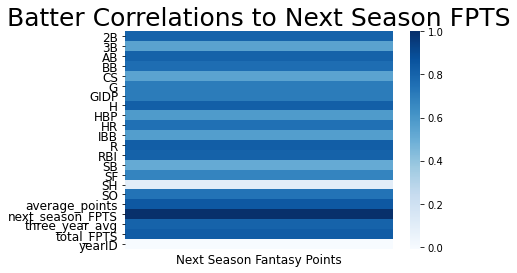

In [32]:
# show a visual representation of the batter correlations to the target variable
batting_heatmap = pd.DataFrame(batting_df.corrwith(batting_df["next_season_FPTS"])).sort_index()

b = sns.heatmap(batting_heatmap, cmap="Blues", yticklabels=True, xticklabels=False)
b.axes.set_title("Batter Correlations to Next Season FPTS",fontsize=25)
b.set_xlabel("Next Season Fantasy Points",fontsize=12)
b.tick_params(labelsize=12)

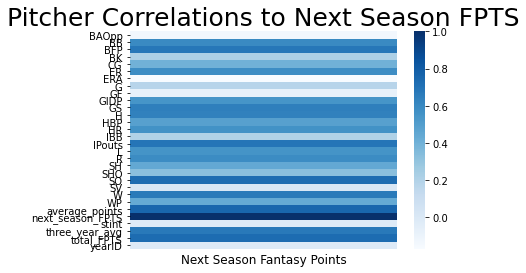

In [33]:
# show a visual representation of the pitcher correlations to the target variable
pitcher_heatmap = pd.DataFrame(pitching_df.corrwith(pitching_df["next_season_FPTS"])).sort_index()

b = sns.heatmap(pitcher_heatmap, cmap="Blues", yticklabels=True, xticklabels=False)
b.axes.set_title("Pitcher Correlations to Next Season FPTS",fontsize=25)
b.set_xlabel("Next Season Fantasy Points",fontsize=12)
b.tick_params(labelsize=10)

In [34]:
# run the Pandas Profiling Profile Report to explore the data in the batting dataframe
batting_profile = ProfileReport(batting_df, title="Batting Profiling Report")
#batting_profile

In [35]:
# run the Pandas Profiling Profile Report to explore the data in the pitching dataframe
pitching_profile = ProfileReport(pitching_df, title="Pitching Profiling Report")
#pitching_profile

In [36]:
# create a new dataframe for the modeling. This includes all of the data except for the year 2019 as we do not
# a next year fantasy points column for that dataframe
batting_model_df = batting_df[batting_df['yearID'] != 2019]
batting_model_df = batting_model_df[['playerID','yearID','G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO',
                                     'IBB','HBP','SH','GIDP','average_points','total_FPTS','next_season_FPTS',
                                     'three_year_avg','teamID','lgID']].reset_index(drop=True)
batting_model_df.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,average_points,total_FPTS,next_season_FPTS,three_year_avg,teamID,lgID
0,aardsda01,2009,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-0.285714,0.0,0.0,-1.0,SEA,AL
1,abreubo01,2009,152,563,96,165,29,3,15,103.0,30.0,8.0,94,113.0,7.0,1.0,0.0,15.0,618.375000,957.0,888.0,1001.0,LAA,AL
2,abreuto01,2009,6,8,0,2,0,0,0,1.0,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,105.000000,6.0,152.0,108.0,LAN,NL
3,abreuwi01,2009,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,-1.0,TBA,AL
4,accarje01,2009,26,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,TOR,AL


In [37]:
# create a new dataframe that is just a list of the playerIDs
batting_model_player_list = batting_model_df['playerID']
# drop the playerID column from the model dataframe because it is a numerical column and cannot be run through a 
# regression model unless it is one hot encoded. This is not advised though as it would create a lot of uncecessary
# columns
batting_model_df = batting_model_df.drop(['playerID'], axis=1)
# create dummy columns for all categorical columns(team, league)
for col in batting_model_df:
    if batting_model_df[col].dtypes == "object":
        dum_df = pd.get_dummies(batting_model_df[col], columns=[col])
        batting_model_df = batting_model_df.join(dum_df)
        batting_model_df = batting_model_df.drop([col], axis=1)
    else:
        pass

# add the playerID column back into the model df once one hot columns created for categorical variables
batting_model_df['playerID'] = batting_model_player_list
batting_model_df.head()

,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,average_points,total_FPTS,next_season_FPTS,three_year_avg,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,FLO,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS,AL,NL,playerID
0,2009,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-0.285714,0.0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,aardsda01
1,2009,152,563,96,165,29,3,15,103.0,30.0,8.0,94,113.0,7.0,1.0,0.0,15.0,618.375000,957.0,888.0,1001.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,abreubo01
2,2009,6,8,0,2,0,0,0,1.0,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,105.000000,6.0,152.0,108.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,abreuto01
3,2009,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,abreuwi01
4,2009,26,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,accarje01


In [38]:
# repeat the above steps for the pitching model
pitching_model_df = pitching_df[pitching_df['yearID'] != 2019]
pitching_model_df = pitching_model_df[['playerID','yearID','W','L','G','GS','CG','SHO','SV','IPouts','H','ER','HR',
                                     'BB','SO','BAOpp','ERA','IBB','WP','HBP','BK','BFP','GF','R','SH','GIDP',
                                     'total_FPTS','average_points','next_season_FPTS','three_year_avg','teamID',
                                     'lgID']].reset_index(drop=True)
pitching_model_df.head()

,playerID,yearID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_FPTS,average_points,next_season_FPTS,three_year_avg,teamID,lgID
0,aardsda01,2009,3,6,73,0,0,0,38,214,49,20,4,34,80,0.190,2.52,3.0,2,0.0,0,296.0,53,23,2.0,2.0,483.333333,254.904762,261.666667,355.0,SEA,AL
1,abreuwi01,2009,0,0,5,0,0,0,0,18,10,7,2,4,6,0.731,25.59,0.0,0,1.0,0,32.0,1,8,0.0,1.0,37.000000,63.777778,0.000000,96.0,TBA,AL
2,accarje01,2009,0,0,26,0,0,0,1,74,23,7,2,17,18,0.267,2.55,1.0,0,2.0,0,107.0,5,8,0.0,3.0,115.666667,129.714286,17.666667,176.0,TOR,AL
3,aceveal01,2009,10,1,43,1,0,0,1,252,69,33,10,16,69,0.220,3.54,2.0,0,5.0,0,337.0,10,36,1.0,5.0,577.000000,313.904762,67.000000,351.0,NYA,AL
4,acostma01,2009,1,1,36,0,0,0,0,112,45,18,4,19,32,0.300,4.34,2.0,3,2.0,0,174.0,17,19,3.0,4.0,207.333333,245.166667,283.666667,191.0,ATL,NL


In [39]:
pitching_model_player_list = pitching_model_df['playerID']
pitching_model_df = pitching_model_df.drop(['playerID'], axis=1)
# create dummy columns for all categorical columns
for col in pitching_model_df:
    if pitching_model_df[col].dtypes == "object":
        dum_df = pd.get_dummies(pitching_model_df[col], columns=[col])
        pitching_model_df = pitching_model_df.join(dum_df)
        pitching_model_df = pitching_model_df.drop([col], axis=1)
    else:
        pass

pitching_model_df['playerID'] = pitching_model_player_list
pitching_model_df.head()

,yearID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_FPTS,average_points,next_season_FPTS,three_year_avg,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,FLO,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS,AL,NL,playerID
0,2009,3,6,73,0,0,0,38,214,49,20,4,34,80,0.190,2.52,3.0,2,0.0,0,296.0,53,23,2.0,2.0,483.333333,254.904762,261.666667,355.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,aardsda01
1,2009,0,0,5,0,0,0,0,18,10,7,2,4,6,0.731,25.59,0.0,0,1.0,0,32.0,1,8,0.0,1.0,37.000000,63.777778,0.000000,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,abreuwi01
2,2009,0,0,26,0,0,0,1,74,23,7,2,17,18,0.267,2.55,1.0,0,2.0,0,107.0,5,8,0.0,3.0,115.666667,129.714286,17.666667,176.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,accarje01
3,2009,10,1,43,1,0,0,1,252,69,33,10,16,69,0.220,3.54,2.0,0,5.0,0,337.0,10,36,1.0,5.0,577.000000,313.904762,67.000000,351.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,aceveal01
4,2009,1,1,36,0,0,0,0,112,45,18,4,19,32,0.300,4.34,2.0,3,2.0,0,174.0,17,19,3.0,4.0,207.333333,245.166667,283.666667,191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,acostma01


In [40]:
# I want to perform various Dimensionality and Feature Reduction strategies in on my feature set. This includes 
# Principal Component Analysis (PCA)and Thresholding Numerical Feature Variance

def create_features(features_dict, test_features_dict, X_train, X_test):
    all_features = X_train
    all_features_title = 'All_Features'
    features_dict[all_features_title] = all_features
    
    all_test_features = X_test
    all_test_features_title = 'All_Features'
    test_features_dict[all_test_features_title] = all_test_features
    
    features = StandardScaler().fit_transform(X_train)
    pca=PCA(n_components=0.99, whiten=True)
    features_pca = pca.fit_transform(features)
    features_pca_title = 'PCA'
    features_dict[features_pca_title] = features_pca
    
    PCA_features_test = StandardScaler().fit_transform(X_test)
    pca = PCA(n_components=0.99, whiten=True)
    test_features_PCA = pca.fit_transform(PCA_features_test)
    test_features_pca_title = 'PCA'
    test_features_dict[test_features_pca_title] = test_features_PCA
    
    
    thresholder = VarianceThreshold(threshold=.5)
    features_high_variance = thresholder.fit_transform(X_train)
    features_vt_title = 'VT'
    features_dict[features_vt_title] = features_high_variance
    
    thresholder = VarianceThreshold(threshold=.5)
    test_features_high_variance=thresholder.fit_transform(X_test)
    test_features_vt_title = 'VT'
    test_features_dict[test_features_vt_title] = test_features_high_variance

In [44]:
# create the X and Y features for modeling
X = batting_model_df.drop(['next_season_FPTS'], axis=1)
y = batting_model_df['next_season_FPTS']
# split the X and Y into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
# drop the playerID column from the test and train X set for modeling
X_train = X_train.drop(['playerID'], axis=1)
X_test = X_test.drop(['playerID'], axis=1)

# create two empty dictionaries to add all of the various feature sets to for modeling
features = {}
test_features = {}
# run the create features function on the X data
create_features(features, test_features, X_train, X_test)
# these are the various regression model types I will be running in my model
model_names = ['linear_model','tree_model','rf_model','nb_model','knn_model','ridge_model',
               'lasso_model']
# these are the model names along with the regression function to be run for each model type
models = {'linear_model': LinearRegression(), 'tree_model': DecisionTreeRegressor(),
          'rf_model': RandomForestRegressor(), 'nb_model': BayesianRidge(compute_score=True),
          'knn_model': neighbors.KNeighborsRegressor(n_neighbors = 10), 'ridge_model': Ridge(),
          'lasso_model': Lasso()}
# scoring that will be used to gauage effectiveness of the models - R2 and MSE
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}

In [45]:
# create a function that runs a N cross validation model comparison for each model type and adds the scores to
# a list for comparison
def get_scores(title,results,feature_name,model,X,y,scoring,cv):
    scores = cross_validate(model,
                             X,y,
                             cv = cv,
                             scoring = scoring, return_train_score=True)
    for key,value in scores.items():
        if key == 'test_R2':
            results.append([title,feature_name,key, round(value.mean(),4)])
        elif key == 'test_MSE':
            results.append([title,feature_name,key, round(value.mean(),4)])
            
# create a function that runs a GridSearch cross validation for each regression type and adds the score to 
# a list for comparison
def get_grid_scores(title,results,feature_name,model,X,y,scoring,cv,param_grid):

    g_cv = GridSearchCV(model,param_grid=param_grid, scoring=scoring, cv=5, refit='R2')
    g_cv.fit(X_train, y_train)
    g_cv.best_params_

    r_squared = r2_score(y_test, g_cv.best_estimator_.predict(X_test))
    mse = mean_squared_error(y_test, g_cv.best_estimator_.predict(X_test))
    
    results.append([title, feature_name, 'test_R2', round(r_squared,4)])
    results.append([title, feature_name, 'test_MSE', round(mse,0)])
    
# create a function that runs a GridSearch with various alphas for the Lasso and Ridge regression types    
def penalty_grid_scores(title,results,feature_name,model,X,y,scoring,cv):
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    param_grid = dict(alpha=alpha)
    model = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
    scores = cross_validate(model,X,y,cv = 5, scoring = scoring, return_train_score=True)
    for key,value in scores.items():
        if key == 'test_R2' or key == 'test_MSE':
            results.append([title,feature_name,key, round(value.mean(),4)])

# create a data frame of all of the different models and their respective scores into one single dataframe 
# for comparison
def create_results(data):
    df = pd.DataFrame(data, columns = ['Model','Feature','Score_Type','Score'])
    df_r2 = df[df['Score_Type'] == 'test_R2']
    df_r2['key'] = df_r2['Model']+df_r2['Feature']
    
    df_rmse = df[df['Score_Type'] == 'test_MSE']
    df_rmse['key'] = df_rmse['Model']+df_rmse['Feature']
    df_rmse = df_rmse[['key','Score_Type','Score']]
    
    df = df_r2.merge(df_rmse, left_on='key', right_on='key')
    df = df.rename(columns={"Score_x": "R2_Score", "Score_y": "MSE_Score"})
    df = df.drop(['Score_Type_x', 'key','Score_Type_y'], axis=1)
    df = df.sort_values(by=['R2_Score', 'MSE_Score'], ascending = False).set_index('Model')
    return df

# run all the models in a list
def run_all_models(features_dict,y):
    results = []
    for key, value in models.items():
        model_type = str(type(value)).split('.')[1]
        title = key
        model = value
        param_grid={'min_samples_split': range(2, 10)}
        if  model_type == 'linear_model':
            if title == 'linear_model' or title == 'nb_model':
                for key, value in features_dict.items():
                    get_scores(title,results,key,model,value,y,scoring = scoring, cv=5)
            elif  title == 'lasso_model' or title == 'ridge_model':
                for key, value in features_dict.items():
                    penalty_grid_scores(title,results,key,model,value,y,scoring = scoring, cv=5)
        elif model_type == 'neighbors':
            for key, value in features_dict.items():
                get_scores(title,results,key,model,value,y,scoring = scoring, cv=5)        
        elif model_type == 'tree' or model_type == 'ensemble':
            for key, value in features_dict.items():
                get_grid_scores(title,results,key,model,value,y,scoring = scoring, cv=5, param_grid = param_grid)
                
    score_df = create_results(results)
    return score_df

# creates a function that once the best model is idenitified, run the test data through that model    
def test_best_model(df):
    best_model_results = []
    
    best_model_details = df[:1].reset_index().values.tolist()
    best_model_details = best_model_details[0]
    best_model_title = best_model_details[0]
    best_model = models.get(best_model_title)
    feature_title = best_model_details[1]
    X_test = test_features.get(feature_title)
    model_type = str(type(best_model)).split('.')[1]
    param_grid={'min_samples_split': range(2, 10)}
    
    if  model_type == 'linear_model':
        if best_model_title == 'linear_model' or best_model_title == 'nb_model':
            get_scores(best_model_title,best_model_results,feature_title,best_model,X_test,y_test,
                       scoring = scoring, cv=5)
        elif  best_model_title == 'lasso_model' or best_model_title == 'ridge_model': 
            penalty_grid_scores(best_model_title,best_model_results,feature_title,best_model,X_test,y_test,
                                scoring = scoring, cv=5)
    elif model_type == 'neighbors':
        get_scores(best_model_title,best_model_results,feature_title,best_model,X_test,y_test,
                   scoring = scoring, cv=5)
    elif model_type == 'tree' or model_type == 'ensemble':
            get_grid_scores(best_model_title,best_model_results,feature_title,best_model,X_test,y_test,
                            scoring = scoring, cv=5, param_grid = param_grid)
            
    best_df = create_results(best_model_results)
    return best_df

In [46]:
# run all of the desired feature sets through all of the desired regression model types
score_df = run_all_models(features,y_train)
# show the dataframe of all the various regression modeling types as well as R2 and MSE scores 
# for each model/feature combination
score_df

,Feature,R2_Score,MSE_Score
Model,,,
lasso_model,All_Features,0.7630,-17168.6110
lasso_model,VT,0.7630,-17168.6110
nb_model,All_Features,0.7625,-17202.1843
nb_model,VT,0.7625,-17202.5348
ridge_model,VT,0.7620,-17240.8473
ridge_model,All_Features,0.7620,-17241.4341
linear_model,VT,0.7619,-17248.1718
linear_model,All_Features,0.7611,-17302.5301
rf_model,All_Features,0.7531,18150.0000


In [47]:
# run the test data through the best model identified above
best_model = test_best_model(score_df)
# show the results of the best model
best_model

,Feature,R2_Score,MSE_Score
Model,,,
lasso_model,All_Features,0.7436,-18755.6776


In [48]:
# create a dataframe of the predicted results for each player
X = batting_model_df.drop(['next_season_FPTS'], axis=1)
y = batting_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train_id = X_train[['playerID','yearID']]
X_train_id['ID'] = X_train_id.index
X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test_id = X_test[['playerID','yearID']]
X_test_id['ID'] = X_test_id.index
X_test = X_test.drop(['playerID','yearID'], axis=1)

lasso_model = Lasso()

lasso_model.fit(X_train, y_train)

lasso_test_preds = lasso_model.predict(X_test)

X_test['Lasso_Pred'] = lasso_test_preds

X_test['Lasso_Pred'] = round(X_test['Lasso_Pred'],0)
                     
X_test['Actual'] = y_test
X_test['ID'] = X_test.index

viewdf = pd.merge(X_test, X_test_id, on='ID')
viewdf

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,average_points,total_FPTS,three_year_avg,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,FLO,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS,AL,NL,Lasso_Pred,Actual,ID,playerID,yearID
0,34,4,1,1,0,1,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,1.111111,9.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,9.0,0.0,3777,wilsocj01,2011
1,32,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-2.0,0.0,4211,fuentbr01,2012
2,52,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-7.0,0.0,563,jenksbo01,2009
3,5,11,1,5,0,0,0,1.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,27.666667,10.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,31.0,74.0,4238,gimenhe01,2012
4,28,58,8,16,2,1,0,3.0,0.0,0.0,1,8.0,0.0,0.0,0.0,0.0,44.000000,53.0,61.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,45.0,10.0,12860,sanchad01,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3284,3,3,1,1,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,3.000000,3.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,10.0,0.0,12025,conlopj01,2018
3285,76,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-14.0,0.0,8906,stroppe01,2015
3286,131,469,56,122,19,1,10,48.0,0.0,1.0,53,58.0,1.0,4.0,3.0,13.0,453.571429,557.0,557.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,412.0,728.0,7536,solarya01,2014
3287,130,470,54,132,17,6,5,48.0,7.0,2.0,23,78.0,4.0,2.0,0.0,18.0,256.000000,528.0,500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,306.0,467.0,8258,hechaad01,2015


In [49]:
# run the 2019 data through the model to get the predicted fantasy points per player for the upcoming season
batting_model_2019 = batting_2019_df[['playerID','yearID','G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO',
                                     'IBB','HBP','SH','GIDP','average_points','total_fpts','three_year_avg','teamID',
                                     'lgID']].reset_index(drop=True)

batting_model_2019_player_list = batting_model_2019['playerID']
batting_model_2019 = batting_model_2019.drop(['playerID'], axis=1)
# create dummy columns for all categorical columns
for col in batting_model_2019:
    if batting_model_2019[col].dtypes == "object":
        dum_df = pd.get_dummies(batting_model_2019[col], columns=[col])
        batting_model_2019 = batting_model_2019.join(dum_df)
        batting_model_2019 = batting_model_2019.drop([col], axis=1)
    else:
        pass

batting_model_2019['playerID'] = batting_model_2019_player_list


batter_19_id = batting_model_2019[['playerID','yearID']]
batter_19_id['ID'] = batter_19_id.index
batting_model_2019 = batting_model_2019.drop(['playerID','yearID'], axis=1)
batting_model_2019['FLO'] = 0

lasso_pred = lasso_model.predict(batting_model_2019)

batting_model_2019['Lasso_Pred'] = lasso_pred
batting_model_2019['Lasso_Pred'] = round(batting_model_2019['Lasso_Pred'],0)

batting_model_2019['ID'] = batting_model_2019.index
viewdf19 = pd.merge(batting_model_2019, batter_19_id , on='ID')
viewdf19 = viewdf19[['playerID','yearID','average_points','total_fpts','three_year_avg','Lasso_Pred']]
viewdf19['Lasso_Pred'] = round(viewdf19['Lasso_Pred'],0)
viewdf19 = viewdf19.sort_values(by='Lasso_Pred', ascending=False)

projections_df = pd.merge(viewdf19,people_df[['playerID','nameFirst','nameLast']],on='playerID',how='left')

projections_df = projections_df[['nameFirst','nameLast','Lasso_Pred','total_fpts']].rename(
    columns={"nameFirst": "First_Name", "nameLast": "Last_Name", "Lasso_Pred": "Projected_2021",
             "total_fpts": "FPTS_2019"})
projections_df['change'] = (projections_df['Projected_2021'] - projections_df['FPTS_2019']) / projections_df['FPTS_2019']
projections_df['percent_change'] = pd.Series(["{0:.2f}%".format(val * 100) for val in projections_df['change']], index = projections_df.index)
projections_df.head()

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change
0,Cody,Bellinger,1256.0,1272.0,-0.012579,-1.26%
1,Pete,Alonso,1122.0,1128.0,-0.005319,-0.53%
2,Mike,Trout,1110.0,1123.0,-0.011576,-1.16%
3,Nolan,Arenado,1079.0,1163.0,-0.072227,-7.22%
4,Mookie,Betts,1075.0,1119.0,-0.039321,-3.93%


In [50]:
# create a function that identifies if a player is a regression candidate for the upcoming season. It is defined 
# as someone who declines in fantasy point performance more than 10% from the previous season. The function also
# idenitifies breakout candidates who are expected to perform better than the previous seaosn by 10% or more
def regression_candidate(row):
    if row['change'] <= -0.10:
        regression = 'Regression'
    elif row['change'] >= 0.10:
        regression = 'Breakout'
    else:
        regression = 'No Change'
    return regression

projections_df['Regression_Status'] = projections_df.apply(regression_candidate, axis=1)

#Top 50 Players Based on Projected Point Totals
projections_df.head(50)

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change,Regression_Status
0,Cody,Bellinger,1256.0,1272.0,-0.012579,-1.26%,No Change
1,Pete,Alonso,1122.0,1128.0,-0.005319,-0.53%,No Change
2,Mike,Trout,1110.0,1123.0,-0.011576,-1.16%,No Change
3,Nolan,Arenado,1079.0,1163.0,-0.072227,-7.22%,No Change
4,Mookie,Betts,1075.0,1119.0,-0.039321,-3.93%,No Change
5,Ronald,Acuna,1066.0,1110.0,-0.039640,-3.96%,No Change
6,Rafael,Devers,1060.0,1213.0,-0.126134,-12.61%,Regression
7,Christian,Yelich,1047.0,1176.0,-0.109694,-10.97%,Regression
8,Francisco,Lindor,1024.0,1038.0,-0.013487,-1.35%,No Change
9,Alex,Bregman,1012.0,1223.0,-0.172527,-17.25%,Regression


In [51]:
# repeat the same steps in the analysis for the pitchers

X = pitching_model_df.drop(['next_season_FPTS'], axis=1)
y = pitching_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test = X_test.drop(['playerID','yearID'], axis=1)

features = {}
test_features = {}

create_features(features, test_features, X_train, X_test)

model_names = ['linear_model','tree_model','rf_model','nb_model','knn_model','ridge_model',
               'lasso_model']

models = {'linear_model': LinearRegression(), 'tree_model': DecisionTreeRegressor(),
          'rf_model': RandomForestRegressor(), 'nb_model': BayesianRidge(compute_score=True),
          'knn_model': neighbors.KNeighborsRegressor(n_neighbors = 10), 'ridge_model': Ridge(),
          'lasso_model': Lasso()}

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}

In [52]:
score_df = run_all_models(features,y_train)
score_df

,Feature,R2_Score,MSE_Score
Model,,,
lasso_model,All_Features,0.6517,-50971.3095
lasso_model,VT,0.6517,-50971.3095
nb_model,All_Features,0.6514,-51009.9919
nb_model,VT,0.6514,-51010.6687
ridge_model,VT,0.6504,-51158.0556
ridge_model,All_Features,0.6502,-51183.3078
linear_model,VT,0.6495,-51291.3316
linear_model,All_Features,0.6475,-51579.4402
knn_model,VT,0.6246,-54970.3111


In [53]:
best_model = test_best_model(score_df)
best_model

,Feature,R2_Score,MSE_Score
Model,,,
lasso_model,All_Features,0.6023,-59393.6995


In [54]:
X = pitching_model_df.drop(['next_season_FPTS'], axis=1)
y = pitching_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train_id = X_train[['playerID','yearID']]
X_train_id['ID'] = X_train_id.index
X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test_id = X_test[['playerID','yearID']]
X_test_id['ID'] = X_test_id.index
X_test = X_test.drop(['playerID','yearID'], axis=1)

lasso_model = Lasso()

lasso_model.fit(X_train, y_train)

lasso_test_preds = lasso_model.predict(X_test)

X_test['Lasso_Pred'] = lasso_test_preds

X_test['Lasso_Pred'] = round(X_test['Lasso_Pred'],0)
                     
X_test['Actual'] = y_test
X_test['ID'] = X_test.index

viewdf = pd.merge(X_test, X_test_id, on='ID')
viewdf

,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_FPTS,average_points,three_year_avg,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,FLO,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS,AL,NL,Lasso_Pred,Actual,ID,playerID,yearID
0,6,10,24,22,2,1,0,395,170,78,19,41,86,0.310,5.33,5.0,2,3.0,2,594.0,0,88,2.0,14.0,609.666667,291.166667,303.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,353.0,450.333333,4582,rusinch01,2015
1,1,2,7,4,0,0,0,76,34,17,7,11,8,0.337,6.04,2.0,2,1.0,0,117.0,1,17,1.0,7.0,69.333333,157.533333,115.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,78.0,0.000000,3080,ortizra01,2013
2,0,2,15,0,0,0,0,51,21,17,6,13,16,0.296,9.00,0.0,3,0.0,1,84.0,3,17,0.0,2.0,87.000000,87.000000,87.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,59.0,0.000000,6330,carroco01,2018
3,0,0,2,0,0,0,0,6,3,0,0,3,1,0.333,0.00,0.0,0,0.0,0,12.0,2,0,0.0,0.0,7.000000,6.333333,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,1.000000,3194,schumsk01,2013
4,3,8,74,0,0,0,50,211,72,23,5,18,56,0.273,2.94,4.0,2,7.0,0,291.0,63,26,2.0,17.0,358.333333,264.976190,368.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,235.0,328.333333,2928,johnsji04,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,6,1,55,0,0,0,12,244,36,22,9,30,143,0.132,2.43,0.0,0,1.0,1,306.0,14,23,1.0,1.0,882.333333,691.888889,644.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,906.0,787.666667,6513,haderjo01,2018
1750,9,10,28,28,0,0,0,495,176,74,23,54,168,0.273,4.04,3.0,11,6.0,1,715.0,0,82,4.0,14.0,1093.000000,687.000000,1023.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,773.0,457.333333,5291,rodonca01,2016
1751,13,9,32,32,1,0,0,614,177,73,22,46,181,0.232,3.21,2.0,5,1.0,0,820.0,0,79,5.0,9.0,1263.666667,849.958333,935.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1121.0,779.333333,3043,minormi01,2013
1752,2,5,8,8,0,0,0,118,51,26,5,18,22,0.311,5.95,0.0,0,1.0,0,183.0,0,30,0.0,6.0,155.333333,119.833333,155.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,88.0,0.000000,3265,waltepj01,2013


In [55]:
pitching_model_2019 = pitching_2019_df[['playerID','yearID','W','L','G','GS','CG','SHO','SV','IPouts','H','ER','HR',
                                     'BB','SO','BAOpp','ERA','IBB','WP','HBP','BK','BFP','GF','R','SH','GIDP',
                                     'average_points','total_fpts','three_year_avg','teamID',
                                     'lgID']].reset_index(drop=True)

pitching_model_2019_player_list = pitching_model_2019['playerID']
pitching_model_2019 = pitching_model_2019.drop(['playerID'], axis=1)

for col in pitching_model_2019:
    if pitching_model_2019[col].dtypes == "object":
        dum_df = pd.get_dummies(pitching_model_2019[col], columns=[col])
        pitching_model_2019 = pitching_model_2019.join(dum_df)
        pitching_model_2019 = pitching_model_2019.drop([col], axis=1)
    else:
        pass

pitching_model_2019['playerID'] = pitching_model_2019_player_list


batter_19_id = pitching_model_2019[['playerID','yearID']]
batter_19_id['ID'] = batter_19_id.index
pitching_model_2019 = pitching_model_2019.drop(['playerID','yearID'], axis=1)
pitching_model_2019['FLO'] = 0

lasso_pred = lasso_model.predict(pitching_model_2019)

pitching_model_2019['Lasso_Pred'] = lasso_pred
pitching_model_2019['Lasso_Pred'] = round(pitching_model_2019['Lasso_Pred'],0)

pitching_model_2019['ID'] = pitching_model_2019.index
viewdf19 = pd.merge(pitching_model_2019, batter_19_id , on='ID')
viewdf19 = viewdf19[['playerID','yearID','average_points','total_fpts','three_year_avg','Lasso_Pred']]
viewdf19['Lasso_Pred'] = round(viewdf19['Lasso_Pred'],0)
viewdf19 = viewdf19.sort_values(by='Lasso_Pred', ascending=False)

projections_df = pd.merge(viewdf19,people_df[['playerID','nameFirst','nameLast']],on='playerID',how='left')

projections_df = projections_df[['nameFirst','nameLast','Lasso_Pred','total_fpts']].rename(
    columns={"nameFirst": "First_Name", "nameLast": "Last_Name", "Lasso_Pred": "Projected_2021",
             "total_fpts": "FPTS_2019"})
projections_df['change'] = (projections_df['Projected_2021'] - projections_df['FPTS_2019']) / projections_df['FPTS_2019']
projections_df['percent_change'] = pd.Series(["{0:.2f}%".format(val * 100) for val in projections_df['change']], index = projections_df.index)
projections_df.head()

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change
0,Gerrit,Cole,2446.0,2120.333333,0.153592,15.36%
1,Justin,Verlander,2253.0,2024.000000,0.113142,11.31%
2,Shane,Bieber,1957.0,1714.333333,0.141552,14.16%
3,Stephen,Strasburg,1914.0,1710.000000,0.119298,11.93%
4,Jack,Flaherty,1842.0,1481.333333,0.243474,24.35%


In [56]:
projections_df['Regression_Status'] = projections_df.apply(regression_candidate, axis=1)

#Top 50 Players Based on Projected Point Totals
projections_df.head(50)

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change,Regression_Status
0,Gerrit,Cole,2446.0,2120.333333,0.153592,15.36%,Breakout
1,Justin,Verlander,2253.0,2024.000000,0.113142,11.31%,Breakout
2,Shane,Bieber,1957.0,1714.333333,0.141552,14.16%,Breakout
3,Stephen,Strasburg,1914.0,1710.000000,0.119298,11.93%,Breakout
4,Jack,Flaherty,1842.0,1481.333333,0.243474,24.35%,Breakout
5,Lance,Lynn,1833.0,1631.333333,0.123621,12.36%,Breakout
6,Jacob,deGrom,1828.0,1610.000000,0.135404,13.54%,Breakout
7,Lucas,Giolito,1790.0,1499.666667,0.193599,19.36%,Breakout
8,Charlie,Morton,1787.0,1616.666667,0.105361,10.54%,Breakout
9,Walker,Buehler,1770.0,1464.333333,0.208741,20.87%,Breakout
